In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from functools import partial
#import seaborn as sn
from sklearn.model_selection import train_test_split

from random import seed
seed(1)
seed = 43

import tensorflow as tf
from tensorflow import keras
from tensorflow import image
from tensorflow import core
from tensorflow.keras import layers
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ",keras.__version__)


kaggle = 0 # Kaggle path active = 1

# change your local path here
if kaggle == 1 :
    MNIST_PATH= '../input/digit-recognizer'
else:
    MNIST_PATH= '../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer'



import os
for dirname, _, filenames in os.walk(MNIST_PATH): 
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Tensorflow Version:  2.3.0
Keras Version:  2.4.0
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\keras_reg_160_10_002.sav
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\keras_reg_jl_160_10_002.sav
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\sample_submission.csv
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\test.csv
../Digit_Recognition_with_a_Deep_Neural_Network/data/input/digit-recognizer\train.csv


# Introduction - MNIST Training Competition
This notebook is a fork of my previous developed notebook for digit recognition. Therefore you will find some parts that look common the the notebook <a href="https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network">Digit Recognition with a Deep Neural Network</a> and some parts that are completely different.

With this I want to take a deeper look in some parts of finetuning hyperparameters. The following list shows some of the finetuning parameters which I will take a look into, one or two ore more ... :
- Dwindling / Exploding Gradients
    - <b>Initializing the Weights</b>
    - <b>Batchnormalization</b>
    - <s>Gradient Clipping</s>
    - <b>Saturated Activataion Functions</b>
- Optimizers
    - <s>Momentum Optimizers</s>
    - <s>Nesterov</s>
    - <s>AdaGrad</s>
    - <s>RMSProp</s>
    - <b>Adam - Optimizer</b>
    - <s>Scheduling Learnrate</s>
- Regulations
    - <s>Drop-Outs</s>
    - <b>l1 / l2 - Regulations</b>
    - <s>Monte-Carlo Drop-out ???</s>
    - <s>Max Norm Regulations ????</s>

Not part of this notebook will be the use of pretrained neural networks (Transferlearning). I just want to list this here for the sake of completeness.

Link to the data topic: https://www.kaggle.com/c/digit-recognizer/data

As in the previous notebooks I will use Tensorflow with Keras. I already mentioned in other notebooks, I will skip some explanations about the data set here. Moreover I will use the already discovered knowledge about the data and transform/prepare the data rightaway.

## Notebook Versions with Different Hyperparameter Configurations
As described in the part above, I used/tested different hyperparameter settings to get a little bit closer to its effects on the neural network and the network's results. I know that there are parameters that effect other parameters when they have changed (and therefore should have been changed as well), however in these cases I just tried a little bit around. Sometimes I kept one or two parameters together, which should be together (e.g. kernel initializer "lecun" and activation function "selu") and sometimes not. The main purpose here was to use them and see the results.

Therefore on Kaggle you can look in the different versions of this notebook if you are interested. In the following I will list some versions with the used hyperparameter config in it:
- Version 7 and 6:
    - Activation Function - "relu"
    - Initializing Weights - "He Normalization"
    - Batchnormalization
- Version 9:
    - Activation Function - "selu"
    - Initializing Weights - "LeCun Normal"
- Version 12 and 14:
    - Regularisation with L1 and L2
- Version 15:
    - Activation Function - "relu"
    - Initializing Weights - "He Normalization"
    - Batchnormalization
    - Optimizer - "Adam"

The current best run was based on the Version 7 with an accuracy of 0.97657 on the kaggle competition "Digit Recognzier"


## My other Projects
If you are interested in some more clearly analysis of the dataset take a look into my other notebooks about the MNIS-dataset:
- Digit Recognition with a Deep Neural Network: https://www.kaggle.com/skiplik/digit-recognition-with-a-deep-neural-network
- Another MNIST Try: https://www.kaggle.com/skiplik/another-mnist-try
- First NN by Detecting Handwritten Characters: https://www.kaggle.com/skiplik/first-nn-by-detecting-handwritten-characters
...




# Get Data

In [2]:
# Data path and file
CSV_FILE_TRAIN='train.csv'
CSV_FILE_TEST='test.csv'

def load_mnist_data(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    return pd.read_csv(csv_path)

def load_mnist_data_manuel(minist_path, csv_file):
    csv_path = os.path.join(minist_path, csv_file)
    csv_file = open(csv_path, 'r')
    csv_data = csv_file.readlines()
    csv_file.close()
    return csv_data

def split_train_val(data, val_ratio):
    return 
    

train = load_mnist_data(MNIST_PATH,CSV_FILE_TRAIN)
test = load_mnist_data(MNIST_PATH,CSV_FILE_TEST)

In [3]:
y = train['label'].copy()
X = train.drop(['label'], axis=1)

# competition dataset
X_test = test.copy()

## Train / Val Split

In [4]:
print("Shape of the Features: ",X.shape)
print("Shape of the Labels: ", y.shape)

Shape of the Features:  (42000, 784)
Shape of the Labels:  (42000,)


### Label Value Count
Visualizing the label distribution of the full train dataset.

In [5]:
train.value_counts('label')

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
dtype: int64

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=seed, test_size=0.20
                                                  , stratify=y
                                                 )

Comparing the equally splitted train- and val-sets based on the given label y.

In [7]:
print("Train - Set Distribution")
print(y_train.value_counts() / y_train.value_counts().sum() )
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print('--------------------------------------------------------------')
print("Val - Set Distribution")
print(y_val.value_counts() / y_val.value_counts().sum() )


Train - Set Distribution
1    0.111518
7    0.104792
3    0.103601
9    0.099702
2    0.099464
6    0.098512
0    0.098363
4    0.096964
8    0.096726
5    0.090357
Name: label, dtype: float64
--------------------------------------------------------------
--------------------------------------------------------------
--------------------------------------------------------------
Val - Set Distribution
1    0.111548
7    0.104762
3    0.103571
9    0.099762
2    0.099405
0    0.098452
6    0.098452
4    0.096905
8    0.096786
5    0.090357
Name: label, dtype: float64


In [8]:
print("X: ", X.shape)
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)

print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)

X:  (42000, 784)
X_train:  (33600, 784)
X_val:  (8400, 784)
y_train:  (33600,)
y_val:  (8400,)


## Building Transforming Piplines

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    #('normalizer', Normalizer())
    ('std_scalar',StandardScaler())
])

## Preprocessing Data

### Data Augmentation with Tensorflow Data Api

In [10]:
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 85 // 100       # croping to 90% of the initial picture 
    return tf.image.random_crop(image, [min_dim, min_dim, 1])


def crop_flip_resize(image, label, flipping = True):
    if flipping == True:
        cropped_image = random_crop(image)
        cropped_image = tf.image.flip_left_right(cropped_image)
    else:
        cropped_image = random_crop(image)

    ## final solution
    resized_image = tf.image.resize(cropped_image, [28,28])
    final_image = resized_image
    #final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label  
    

In [11]:
X_val.shape

(8400, 784)

In [12]:
# converting dataframe format into tensorflow compatible format.
X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.values.reshape(X_val.shape[0], 28, 28, 1)

X_train_crop = X_train.copy()
X_val_crop = X_val.copy()

In [13]:
# Creating tensorbased dataset 

training_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train, tf.float32),
            tf.cast(y_train, tf.int32)
        )
    )
)


val_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
             tf.cast(X_val, tf.float32),
             tf.cast(y_val, tf.int32)
        )
    )
)


training_crop_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_train_crop, tf.float32),
            tf.cast(y_train, tf.int32)
        )
    )
)


val_crop_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
             tf.cast(X_val_crop, tf.float32),
             tf.cast(y_val, tf.int32)
        )
    )
)


In [14]:
# resizing, croping images via self build function
training_crop_dataset = training_crop_dataset.map(partial(crop_flip_resize, flipping=False))
val_crop_dataset = val_crop_dataset.map(partial(crop_flip_resize, flipping=False))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


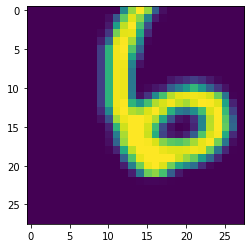

In [15]:
# Visualizing a croped, flipped, resized image from new dataset.
for X_values, y_values in training_crop_dataset.take(1):
    for index in range(1):
        plt.imshow(X_values)

In [16]:
# concate the two datasets
training_dataset_all = training_dataset.concatenate(training_crop_dataset)
val_dataset_all = val_dataset.concatenate(val_crop_dataset)

In [17]:
print("training_dataset_all length: ", len(list(training_dataset_all)))
print("val_dataset_all length: ", len(list(val_dataset_all)))


training_dataset_all length:  67200
val_dataset_all length:  16800


In [18]:
# shuffeling and batching data
tf.random.set_seed(seed)

train_ds = training_dataset_all.shuffle(10000).batch(32).prefetch(1)
val_ds = val_dataset_all.shuffle(8000).batch(32).prefetch(1)

# Building a Deep Neural Network

## Preparing Model Visualization with Tensorboard (not for Kaggle)

In [19]:
root_logdir = "../../tensorboard-logs"

print("Relative root_logdir: ",root_logdir)

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

Relative root_logdir:  ../../tensorboard-logs


In [20]:
run_logdir = get_run_logdir()
print("Current run logdir for Tensorboard: ", run_logdir)

Current run logdir for Tensorboard:  ../../tensorboard-logs\run_2021_10_29-15_44_15


In [21]:
run_logdir

'../../tensorboard-logs\\run_2021_10_29-15_44_15'

### Keras Callbacks for Tensorboard
With Keras there is a way of using Callbacks for the Tensorboard to write log files for the board and visualize the different graphs (loss and val curve)


In [22]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Building Model Architecture

In [23]:
from keras.layers import LeakyReLU

input_shape=[784]
input_shape_notFlattened=[28,28]


learning_rt = 1e-03 
activation_fn = "relu"
initializer = "he_normal"
regularizer =  None #keras.regularizers.l2(0.01)

# Model building
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=input_shape_notFlattened))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer)) ## add  kernel_regularizer=keras.regularizers.l2(0.01)) ???
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))

model.add(keras.layers.Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))


optimizer = keras.optimizers.Adam(learning_rate=learning_rt)


model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'] )


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 300)               9

## Model Checkpoints

In [25]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_train_model.h5", save_best_only=True, save_weights_only=False)

## Model Training

In [223]:
history = model.fit(train_ds, epochs=200, validation_data=(val_ds), callbacks=[checkpoint_cb, keras.callbacks.EarlyStopping(patience=20), tensorboard_cb])

Epoch 1/200
2100/2100 [==============================] - 12s 6ms/step - loss: 0.4569 - accuracy: 0.8576 - val_loss: 0.2474 - val_accuracy: 0.9230
Epoch 2/200
2100/2100 [==============================] - 11s 5ms/step - loss: 0.2602 - accuracy: 0.9186 - val_loss: 0.2063 - val_accuracy: 0.9343
Epoch 3/200
2100/2100 [==============================] - 10s 5ms/step - loss: 0.2050 - accuracy: 0.9364 - val_loss: 0.1598 - val_accuracy: 0.9527
Epoch 4/200
2100/2100 [==============================] - 10s 5ms/step - loss: 0.1768 - accuracy: 0.9446 - val_loss: 0.1508 - val_accuracy: 0.9554
Epoch 5/200
2100/2100 [==============================] - 10s 5ms/step - loss: 0.1465 - accuracy: 0.9538 - val_loss: 0.1339 - val_accuracy: 0.9592
Epoch 6/200
2100/2100 [==============================] - 10s 5ms/step - loss: 0.1319 - accuracy: 0.9584 - val_loss: 0.1249 - val_accuracy: 0.9628
Epoch 7/200
2100/2100 [==============================] - 10s 5ms/step - loss: 0.1169 - accuracy: 0.9633 - val_loss: 0.1153 -

## Visualizing the Progress

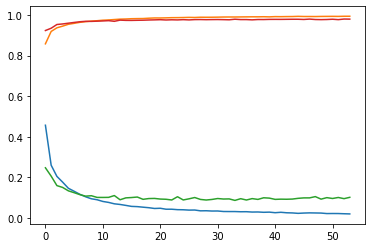

In [224]:
plt.plot(pd.DataFrame(history.history))
plt.show()

### Model Training with Full Dataset 
In this part I will train the model with the full dataset. This time I will use the discovered hyperparameters from previous section.

In [26]:

# Model building
model_full = keras.models.Sequential()

model_full.add(keras.layers.Flatten(input_shape=input_shape_notFlattened))
model_full.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer)) ## add  kernel_regularizer=keras.regularizers.l2(0.01)) ???
model_full.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model_full.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model_full.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model_full.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))
model_full.add(keras.layers.BatchNormalization())
model_full.add(keras.layers.Dense(300, activation=activation_fn, kernel_initializer=initializer, kernel_regularizer= regularizer))

model_full.add(keras.layers.Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))


optimizer = keras.optimizers.SGD(learning_rate=learning_rt)


model_full.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'] )

In [27]:
model_full.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
dense_7 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_7 (Batch (None, 300)               1200      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               90300     
_________________________________________________________________
batch_normalization_8 (Batch (None, 300)               1200      
_________________________________________________________________
dense_9 (Dense)              (None, 300)              

In [28]:
# creating a new log dir for tensorboard
tensorboard_cb_f = keras.callbacks.TensorBoard(get_run_logdir())
checkpoint_cb_f = keras.callbacks.ModelCheckpoint("my_modell_full.h5", save_best_only=False, save_weights_only=False)

In [29]:
# preparing full features set (X) for the tensorflow data api

training_dataset_all = training_dataset.concatenate(training_crop_dataset)
val_dataset_all = val_dataset.concatenate(val_crop_dataset)

training_ds_all = training_dataset_all.concatenate(val_dataset_all)

training_ds_all = training_ds_all.shuffle(20000).batch(32).prefetch(1)

In [30]:
# Train the model again pleeeeease with all you got .... especially the new transformed data matrix X 
history_full = model_full.fit(training_ds_all, epochs=60, callbacks=[tensorboard_cb_f, checkpoint_cb_f])

Epoch 1/60
   1/2625 [..............................] - ETA: 0s - loss: 3.2111 - accuracy: 0.0625WARNING:tensorflow:From D:\anaconda3\envs\wingpuflake_keras\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2625/2625 [==============================] - 10s 4ms/step - loss: 1.4008 - accuracy: 0.5414
Epoch 2/60
2625/2625 [==============================] - 10s 4ms/step - loss: 0.7951 - accuracy: 0.7428
Epoch 3/60
2625/2625 [==============================] - 10s 4ms/step - loss: 0.6236 - accuracy: 0.7997
Epoch 4/60
2625/2625 [==============================] - 10s 4ms/step - loss: 0.5300 - accuracy: 0.8311
Epoch 5/60
2625/2625 [==============================] - 10s 4ms/step - loss: 0.4738 - accuracy: 0.8485
Epoch 6/60
2625/2625 [==============================] - 10s 4ms/step - loss: 0.4314 - accuracy: 0.8623
Epo

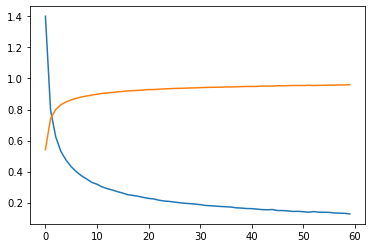

In [31]:
plt.plot(pd.DataFrame(history_full.history))
plt.show()

# Image Prediction of Unknown Data (Test Data)

## Peparing Test Data
As well as previously done, we need to create a TF dataset of the test set as well.

In [32]:
# converting dataframe format into tensorflow compatible format.
X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1)


test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(X_test, tf.float32)
        )
    )
)

In [36]:
test_dataset

<TensorSliceDataset shapes: (28, 28, 1), types: tf.float32>

In [37]:
test_ds = test_dataset.batch(32).prefetch(1)

## Creating Competition File

In [38]:
mnist_competition_file = pd.DataFrame(columns=['ImageId','Label'])

## Prediction of Testdata

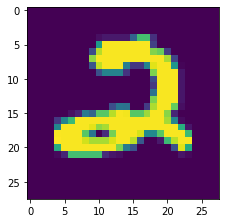

In [39]:
# Visualizing the image
plt.figure(figsize=(12, 12))
for X_batch in test_ds.take(1):
    for index in range(1):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index])

plt.show()

In [49]:
for element in test_ds.take(1):
    print("Propability of all lables for given pixels: ", model_full.predict(test_ds.take(1))[0])

Propability of all lables for given pixels:  [2.4089815e-08 7.4411575e-05 9.9990892e-01 5.6008630e-06 4.7317304e-08
 2.3272852e-07 7.5315036e-08 1.0460487e-05 1.8115448e-07 1.3897583e-09]


In [48]:
print("Predicted Digit: ",np.argmax(model_full.predict(test_ds.take(1))[0]))

Predicted Digit:  2


In [116]:
predictions = model_full.predict(test_ds)                                                                           # predict the probability
predictions = np.argmax(predictions, axis=1)                                                                        # getting the predicted digit numbers based ont the probability of every np element 
mnist_competition_file = pd.DataFrame(predictions)                                                                  # converting into df
mnist_competition_file.index += 1                                                                                   # index should start at 1
mnist_competition_file.reset_index(level=0, inplace=True)                                                           # make the index a column 
mnist_competition_file = mnist_competition_file.rename(columns={"index": "ImageId", 0: "Label"}, errors="raise")    # renamen them according to the competition requirements

In [117]:
mnist_competition_file

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [118]:
mnist_competition_file.ImageId = mnist_competition_file.ImageId.astype(int)
mnist_competition_file.Label = mnist_competition_file.Label.astype(int)

In [119]:
mnist_competition_file.to_csv('mnist_submission.csv', index=False)